In [25]:
import numpy as np
from fractions import Fraction
from math import floor, gcd, log
 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFTGate
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
import os

import time

QiskitRuntimeService.save_account(
    token=os.getenv('IBMQ_API_KEY'),
    channel="ibm_quantum_platform",
    overwrite=True
)

In [26]:
phase = QuantumRegister(3, 'phase')
work  = QuantumRegister(5, 'work')
c = ClassicalRegister(3, 'c')

qc = QuantumCircuit(phase, work, c)

In [27]:
def c_mult_2_mod_21(qc, control, work):
    qc.cx(control, work[1])
    qc.cx(control, work[2])

def c_mult_4_mod_21(qc, control, work):
    qc.cx(control, work[2])
    qc.cx(control, work[3])

def c_mult_16_mod_21(qc, control, work):
    qc.cx(control, work[0])
    qc.cx(control, work[4])

In [28]:
def iqft(qc, q):
    qc.h(q[2])
    qc.cp(-3.14159/2, q[1], q[2])
    qc.h(q[1])
    qc.cp(-3.14159/4, q[0], q[2])
    qc.cp(-3.14159/2, q[0], q[1])
    qc.h(q[0])

In [29]:
qc.x(work[0])
qc.h(phase)

c_mult_2_mod_21(qc, phase[0], work)
c_mult_4_mod_21(qc, phase[1], work)
c_mult_16_mod_21(qc, phase[2], work)

iqft(qc, phase)
qc.measure(phase, c)

In [30]:
service = QiskitRuntimeService()
backend = service.backend("ibm_marrakesh")  # or any 7–27q device
sampler = Sampler(backend)

from qiskit import transpile
tqc = transpile(qc, backend, optimization_level=3)

job = sampler.run([tqc], shots=2048)

qiskit_runtime_service.__init__:WARNING:2026-02-03 21:09:34,850: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: open-instance. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2026-02-03 21:09:34,851: Using instance: open-instance, plan: open


In [41]:
result = job.result()

counts = result[0].data.c.get_counts()
print(counts)

{'011': 239, '100': 277, '001': 250, '111': 282, '101': 255, '010': 257, '110': 259, '000': 229}


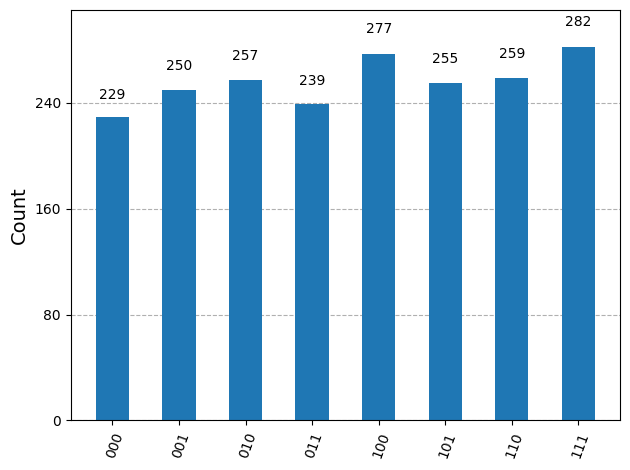

In [42]:
plot_histogram(counts)

In [47]:
def find_order(measured_value, t, a, N, max_den=50):
    """
    measured_value: integer measurement outcome
    t: number of phase qubits
    """
    frac = Fraction(measured_value, 2**t).limit_denominator(max_den)
    r = frac.denominator

    # Verify order
    if pow(a, r, N) == 1:
        return r
    return None

In [45]:
def find_order_from_measurement(m, t, a, N, max_den=20, max_mult=6):
    frac = Fraction(m, 2**t).limit_denominator(max_den)
    d = frac.denominator

    for k in range(1, max_mult + 1):
        r = k * d
        if pow(a, r, N) == 1:
            return r
    return None

def get_candidate_rs(counts, t, a, N, top_k=6):
    candidates = sorted(counts.items(), key=lambda x: -x[1])[:top_k]
    rs = set()

    for bitstring, _ in candidates:
        m = int(bitstring, 2)
        r = find_order_from_measurement(m, t, a, N)
        if r:
            rs.add(r)

    return rs

In [49]:
def shor_factors_from_r(r, a, N):
    if r % 2 != 0:
        return None

    x = pow(a, r // 2, N)

    if x == N - 1 or x == 1:
        return None

    f1 = gcd(x - 1, N)
    f2 = gcd(x + 1, N)

    if f1 * f2 == N:
        return f1, f2

    return None

In [50]:
N = 21
a = 2
t = 3   # number of phase qubits

rs = get_candidate_rs(counts, t, a, N)

print("Candidate r values:", rs)

for r in rs:
    factors = shor_factors_from_r(r, a, N)
    if factors:
        print(f"SUCCESS: r = {r}, factors = {factors}")

Candidate r values: {24, 12, 6}
SUCCESS: r = 6, factors = (7, 3)
